In [1]:
import numpy as np
import matplotlib.pyplot as plt
from igraph import *
import pandas as pd
import requests

In [2]:
#os.chdir('../../')
os.getcwd()
arpack_options.maxiter=300000

In [3]:
dismat = np.load('./npydata/all_data_k_means/dismat.npy')

In [4]:
names = np.load('./npydata/all_data_k_means/names_train.npy')

In [5]:
dismat.shape

(1815, 1815)

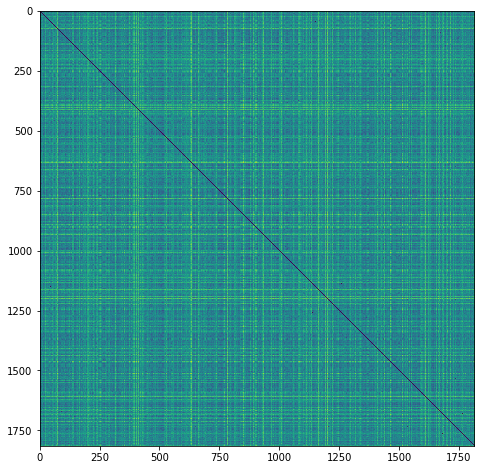

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(dismat)
plt.show()

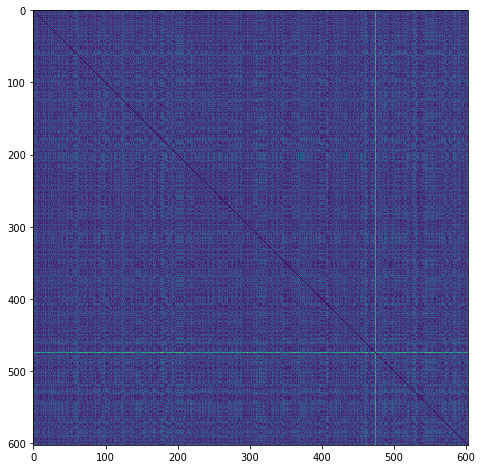

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(dismat)
plt.show()

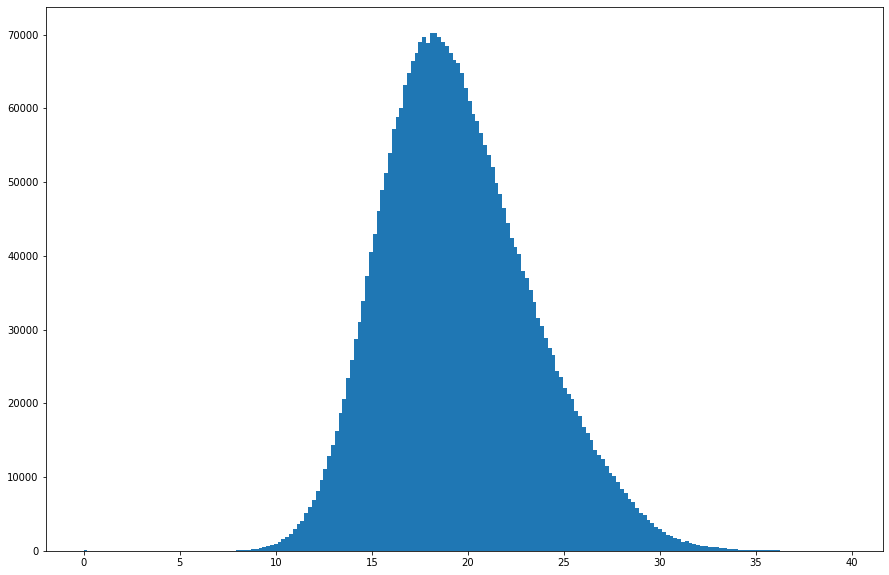

In [7]:
dismatflat = dismat.reshape((-1,))
dismatflat = dismat[dismat != 0] # Too many ones result in a bad histogram so we remove them
plt.figure(figsize=(15, 10))
_ = plt.hist(dismatflat, bins=200)

In [160]:
adjmtx = dismat.copy()
#np.fill_diagonal(adjmtx, np.min(dismat[dismat > 0]))
#adjmtx = (dismat - np.min(adjmtx[adjmtx > 0])) / (np.max(adjmtx) - np.min(adjmtx[adjmtx > 0]))

In [161]:
np.min(dismat[dismat > 0])

2.3841858e-07

In [162]:
np.max(adjmtx) - np.min(adjmtx[adjmtx > 0])

39.61254

In [163]:
np.min(adjmtx[adjmtx > 0])

2.3841858e-07

In [164]:
np.fill_diagonal(adjmtx, 0)

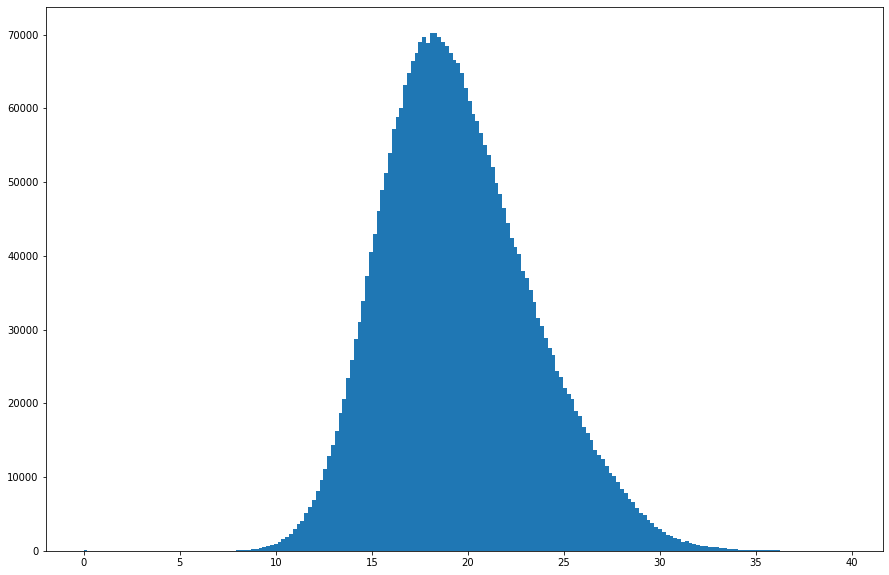

In [165]:
adjmtxflat = adjmtx.reshape((-1,))
adjmtxflat = adjmtxflat[adjmtxflat != 0] # Too many ones result in a bad histogram so we remove them
plt.figure(figsize=(15, 10))
_ = plt.hist(adjmtxflat, bins=200)

# 根据degree 来筛掉一些点

In [167]:
#drawdata = adjmtx[:300, :300].copy()
drawdata = adjmtx.copy()
#threshold = max([np.partition(col, 1)[1] for col in drawdata])
#threshold = 0.036
threshold = 9
drawdata[drawdata > threshold] = 0

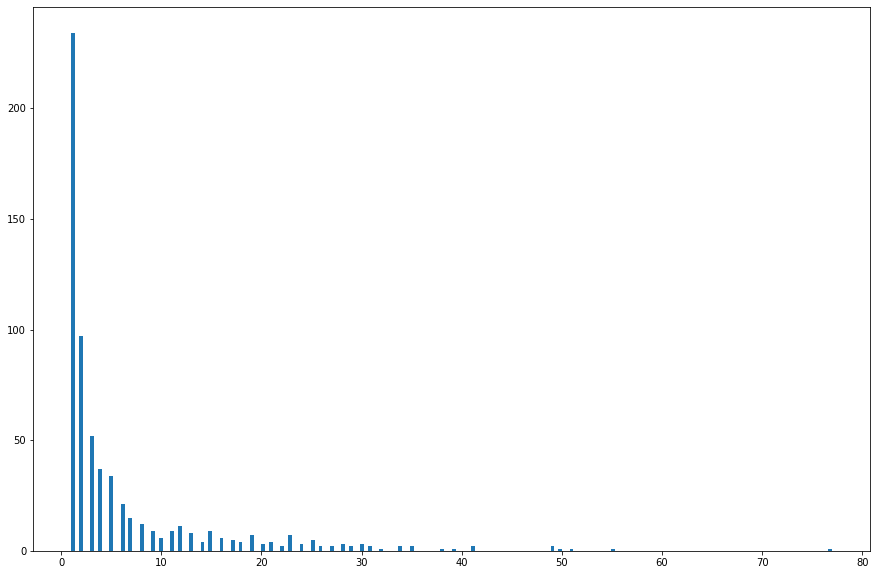

In [144]:
plt.figure(figsize=(15, 10))
_ = plt.hist([len([item for item in col if item > 0]) for col in drawdata if len([item for item in col if item > 0]) != 0], bins=200)

In [153]:
for i, item in enumerate(drawdata):
    if sum(drawdata[i] > 0) > 20:
        drawdata[:, i:i+1] = 0
        drawdata[i:i+1, :] = 0

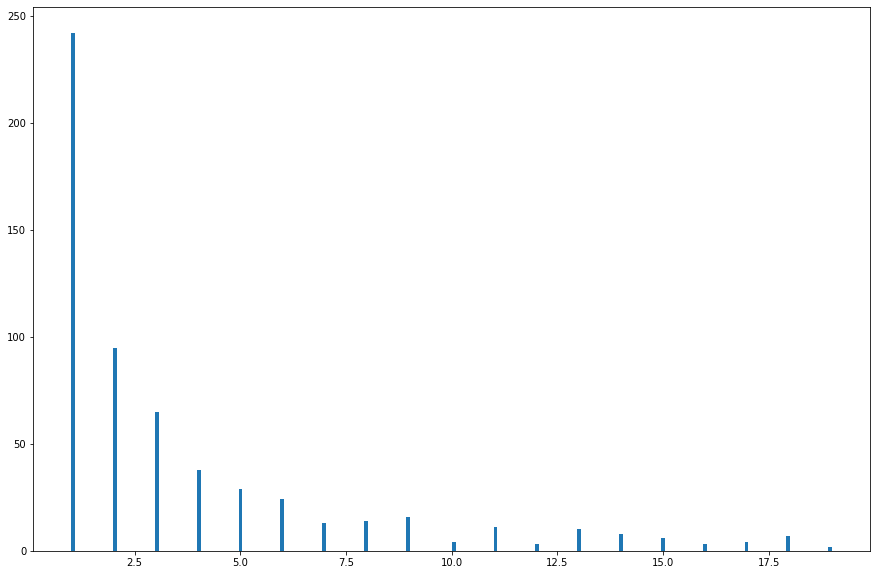

In [154]:
plt.figure(figsize=(15, 10))
_ = plt.hist([len([item for item in col if item > 0]) for col in drawdata if len([item for item in col if item > 0]) != 0], bins=200)

In [168]:
g = Graph.Adjacency((drawdata > 0).tolist(), "MAX")
g.es['weight'] = drawdata[drawdata > 0]
#g.vs['label'] = names.tolist()[:300]
g.vs['label'] = list(range(0, len(names)))

In [169]:
b = g.community_leading_eigenvector(weights=g.es["weight"])
b.summary()

'Clustering with 1815 elements and 1543 clusters'

In [103]:
temp = pd.DataFrame(drawdata)

In [116]:
drawdata[1,322]

0.0

In [ ]:
nodes

In [99]:
g.ecount()

5343

In [100]:
os.getcwd()

'/home/gs/git-repos/nus'

In [ ]:
layout = g.layout("fr")
_ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="./try22.5.pdf")

In [ ]:
for cluster in b:
    for school in cluster:
        print(names[school])
    print('\n\n\n\n')

In [57]:
import os
from shutil import copyfile

In [113]:
os.getcwd()

'/home/gs/git-repos/nus/Cleaned/ChinaSchool'

In [274]:
#os.chdir('./Cleaned/ChinaSchool/')
for index, cluster in enumerate(b):
    if len(cluster) > 3:
        os.mkdir('../../clusters_new_encoder/cluster' + str(index))
        for index_sch in cluster:
            copyfile(names[index_sch][:-6] + '.jpeg', '../../clusters_new_encoder/cluster' + str(index) + '/' + names[index_sch][:-6] + '.jpeg')

In [68]:
os.getcwd()

'/home/gs/git-repos/nus/Cleaned/ChinaSchool'

In [60]:
b[0]

[0, 71, 152, 213]

In [97]:
g.es[0]['weight']

0.036467254

# 参数为0.036 / new 0.015

In [131]:
b.summary()

'Clustering with 1815 elements and 835 clusters'

In [46]:
def find_index_in_cluster(index):
    for i, cluster in enumerate(b):
            if index in cluster:
                print(str(i) + 'th cluster\n')
                print(names[index])
                print('\n\n')
                return names[index]
                #for item in cluster:
                #    print(names[item])

In [47]:
def find_school_index(name):
    return names.tolist().index(name + '_China')

In [48]:
def list_cluster(index):
    print(b[index])
    print([names[x][:-6] for x in b[index]])

In [ ]:
#for index, cluster in enumerate(b):
#    if len(cluster) >= 3:
#        print(index)

In [292]:
#find_school_index('安徽医科大学')

139

In [175]:
#c = list(map(lambda x : find_index_in_cluster(x), a))

In [174]:
#os.getcwd()
#for sch_name in c:
#    print(sch_name)
#    print(sch_name[:-6] + '.jpeg')
#    print('../../test/' + names[index_sch][:-6] + '.jpeg')
#    copyfile(sch_name[:-6] + '.jpeg', '../../test/' + sch_name[:-6] + '.jpeg')

# 转换格式

In [50]:
import json

In [51]:
def cluster_index(index):
    for i, cluster in enumerate(b):
            if index in cluster:
                return i

In [52]:
g.ecount()

9453

In [57]:
def handle_encode(target):
    if not target:
        return target
    if target.endswith('China') or target.endswith('Hong Kong'):
        return target.encode('cp437').decode('utf8')
    else:
        return target

In [170]:
links = [{"source": a, "target": b} for a in range(drawdata.shape[0]) for b in range(drawdata.shape[0]) if drawdata[a, b] > 0 and a < b]

In [171]:
#nodes = [{"id" : a, "description" : handle_encode(names[a]).replace("'", '&#39;').replace('"', "&quot;"), "user": cluster_index(a)} for a in range(drawdata.shape[0]) if np.sum(drawdata[a]) > 0]

In [172]:
nodes = [{"id" : a, "description" : names[a].replace("'", '&#39;').replace('"', "&quot;"), "user": cluster_index(a)} for a in range(drawdata.shape[0]) if np.sum(drawdata[a]) > 0]

In [173]:
with open('./graph_try_all.json', 'w') as f:
    f.write(str({"links": links, "nodes": nodes}).replace("'", '"'))

In [51]:
t = {"links": links, "nodes": nodes}

# 迭代不同的阈值

In [24]:
for i in range(10, 25):
    drawdata = adjmtx.copy()
    threshold = i
    drawdata[drawdata > threshold] = 0
    g = Graph.Adjacency((drawdata > 0).tolist(), "MAX")
    g.es['weight'] = drawdata[drawdata > 0]
    #g.vs['label'] = names.tolist()[:300]
    g.vs['label'] = list(range(0, len(names)))
    b = g.community_leading_eigenvector(weights=g.es["weight"])
    print(b.summary())
    print(str(i) +'th CD')
    layout = g.layout("fr")
    _ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="pdfs/selected_data_" + str(i) +"_fr.pdf")
    layout = g.layout("kk")
    _ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="pdfs/selected_data_" + str(i) +"_kk.pdf")
    

Clustering with 603 elements and 603 clusters
10th CD
Clustering with 603 elements and 603 clusters
11th CD
Clustering with 603 elements and 598 clusters
12th CD
Clustering with 603 elements and 585 clusters
13th CD
Clustering with 603 elements and 578 clusters
14th CD
Clustering with 603 elements and 565 clusters
15th CD
Clustering with 603 elements and 543 clusters
16th CD
Clustering with 603 elements and 518 clusters
17th CD
Clustering with 603 elements and 467 clusters
18th CD
Clustering with 603 elements and 421 clusters
19th CD
Clustering with 603 elements and 362 clusters
20th CD
Clustering with 603 elements and 305 clusters
21th CD
Clustering with 603 elements and 249 clusters
22th CD
Clustering with 603 elements and 198 clusters
23th CD
Clustering with 603 elements and 171 clusters
24th CD


# 最终阈值选为22.5

In [55]:
os.getcwd()

'/home/gs/git-repos/nus'

In [56]:
os.chdir('./test')

In [59]:
# Read data
import urllib
import zipfile
file = urllib.request.urlretrieve('https://raw.githubusercontent.com/Langford-ta'+
                                  'ng/University-Logo-Deep-Learning-Community-Det'+
                                  'ection/master/data.zip', 'data.zip')

# Unzip data archive
if os.path.exists("data"):
    shutil.rmtree("data")
zip_ref = zipfile.ZipFile("data.zip", 'r')
zip_ref.extractall()
zip_ref.close()
